In [1]:
# To add a new cell, type '# %%'
# To add a new markdown cell, type '# %% [markdown]'
# %% [markdown]
# ## Import necessary dependencies


In [2]:
import pandas
from matplotlib import pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
import numpy
from sklearn.feature_selection import chi2
from PIL import Image
from collections import Counter
import re
import sqlite3
import nltk
from keras.preprocessing import text
from keras.utils import np_utils
from keras.preprocessing import sequence
import pydot


Using TensorFlow backend.


 ## Load in the data from the database

In [3]:
dbconn = sqlite3.connect('./data/newsclassifier.db')
train_data_df = pandas.read_sql_query('SELECT * FROM train_data_sample', dbconn)
headline_bagofwords_df = pandas.read_sql_query('SELECT * FROM headline_bagofwords', dbconn)
dbconn.commit()
dbconn.close()


 ### Check the if the data was loaded correctly

In [4]:
train_data_df.head()



,index,category,headline,content,headline_cleaned,content_cleaned
0,30870,2,"NHL on Ice, Maybe for Whole 2004-05 Season (AP)","AP - No shots, no saves, no goals. The Nationa...","NHL on Ice, Maybe for Whole 2004-05 Season","AP - No shots, no saves, no goals. The locked..."
1,7738,2,Rowers to be punished for criticism of teammate,ROWER Sally Robbins #39;s teammates are expect...,Rowers to be punished for criticism of teammate,ROWER Sally Robbins #39;s teammates are expect...
2,25351,2,Changing Directions,"Over at USA Today -- Slogan: ""All the News Tha...",Changing Directions,"Over at -- Slogan: ""All the News That's Fit t..."
3,74309,4,Cassini snapshots murky moon Titan,The Cassini probe got the first close-up photo...,Cassini snapshots murky moon Titan,The Cassini probe got the first close-up photo...
4,88347,1,Farewell Yasser Arafat,"GAZA CITY, 12 November 2004 - The world will b...",Farewell Yasser Arafat,"GAZA CITY, 12 November 2004 - The world will b..."


In [5]:
headline_bagofwords_df.head()



,index,abuse,acc,accept,add,adds,afghan,afp,africa,african,...,xp,yahoo,yankees,year,years,yen,yields,yukos,zero,zurich
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
train_data_df.drop('index', axis=1, inplace=True)
train_data_df.head()



,category,headline,content,headline_cleaned,content_cleaned
0,2,"NHL on Ice, Maybe for Whole 2004-05 Season (AP)","AP - No shots, no saves, no goals. The Nationa...","NHL on Ice, Maybe for Whole 2004-05 Season","AP - No shots, no saves, no goals. The locked..."
1,2,Rowers to be punished for criticism of teammate,ROWER Sally Robbins #39;s teammates are expect...,Rowers to be punished for criticism of teammate,ROWER Sally Robbins #39;s teammates are expect...
2,2,Changing Directions,"Over at USA Today -- Slogan: ""All the News Tha...",Changing Directions,"Over at -- Slogan: ""All the News That's Fit t..."
3,4,Cassini snapshots murky moon Titan,The Cassini probe got the first close-up photo...,Cassini snapshots murky moon Titan,The Cassini probe got the first close-up photo...
4,1,Farewell Yasser Arafat,"GAZA CITY, 12 November 2004 - The world will b...",Farewell Yasser Arafat,"GAZA CITY, 12 November 2004 - The world will b..."


In [7]:
headline_bagofwords_df.drop('index', axis=1, inplace=True)
headline_bagofwords_df.head()



,abuse,acc,accept,add,adds,afghan,afp,africa,african,agree,...,xp,yahoo,yankees,year,years,yen,yields,yukos,zero,zurich
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


 ### We have bag of words already, let's make a Bag of N-Grams

In [8]:
# Use countvectorizer to get a word vector
cv = CountVectorizer(min_df = 2, lowercase = True, token_pattern=r'(?u)\b[A-Za-z]{2,}\b', 
                        strip_accents = 'ascii', ngram_range = (2, 3), 
                        stop_words = 'english')
cv_matrix = cv.fit_transform(train_data_df.headline_cleaned).toarray()

# below is if wanted to define a specific category for the data.
# cv_matrix = cv.fit_transform(train_data_df[train_data_df.category == 1].headline_cleaned).toarray()

# get all unique words in the corpus
vocab = cv.get_feature_names()

# produce a dataframe including the feature names
headline_bagofngrams_df = pandas.DataFrame(cv_matrix, columns=vocab)


 ### Make sure we got the dataframe output for the Bag of N-Grams

In [9]:
headline_bagofngrams_df.head()


,al qaeda,allows settler,allows settler homes,anti piracy,audit finds,bird flu,blast kills,blow icann,blow icann suit,bomber kills,...,title hopes,tokyo stocks,verisign dealt,verisign dealt legal,version windows,west bank,win china,win china open,windows xp,world cup
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


 ### Let's explore the data we got through plots and tables

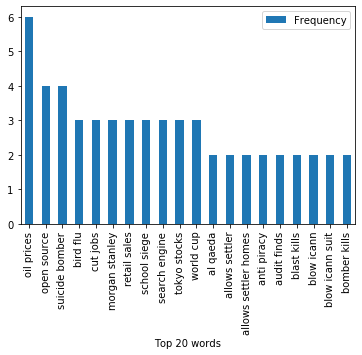

In [10]:
word_count_dict = {}
for word in vocab:
    word_count_dict[word] = int(sum(headline_bagofngrams_df.loc[:, word]))

counter = Counter(word_count_dict)

freq_df = pandas.DataFrame.from_records(counter.most_common(20),
                                        columns=['Top 20 words', 'Frequency'])
freq_df.plot(kind='bar', x='Top 20 words');



 ## TF/IDF

 ### Unigram TF/IDF

In [11]:
tfidf_vect = TfidfVectorizer(sublinear_tf = True, min_df = 2, lowercase = True, 
                             strip_accents = 'ascii', ngram_range = (1, 1), 
                             stop_words = 'english', use_idf = True, token_pattern=r'(?u)\b[A-Za-z]{2,}\b')
tfidf_unigram = tfidf_vect.fit_transform(train_data_df.headline_cleaned).toarray()

# get all unique words in the corpus
vocab = tfidf_vect.get_feature_names()

tfidf_unigram = pandas.DataFrame(numpy.round(tfidf_unigram, 2), columns = vocab)
tfidf_unigram.head()


,abuse,acc,accept,add,adds,afghan,africa,african,agree,agrees,...,xp,yahoo,yankees,year,years,yen,yields,yukos,zero,zurich
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


 ### N-Gram TF/IDF

In [12]:
tfidf_vect = TfidfVectorizer(sublinear_tf = True, min_df = 2, lowercase = True, 
                             strip_accents = 'ascii', ngram_range = (2, 3), 
                             stop_words = 'english', use_idf = True, token_pattern=r'(?u)\b[A-Za-z]{2,}\b')
tfidf_ngram = tfidf_vect.fit_transform(train_data_df.headline_cleaned).toarray()

# get all unique words in the corpus
vocab = tfidf_vect.get_feature_names()

tfidf_ngram = pandas.DataFrame(numpy.round(tfidf_ngram, 2), columns = vocab)
tfidf_ngram.head()


,al qaeda,allows settler,allows settler homes,anti piracy,audit finds,bird flu,blast kills,blow icann,blow icann suit,bomber kills,...,title hopes,tokyo stocks,verisign dealt,verisign dealt legal,version windows,west bank,win china,win china open,windows xp,world cup
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


 ### Character TF/IDF

In [13]:
tfidf_vect = TfidfVectorizer(analyzer = 'char', sublinear_tf = True, min_df = 2, 
                             lowercase = True, strip_accents = 'ascii', ngram_range = (2, 3), 
                             stop_words = 'english', use_idf = True, token_pattern=r'\w{1,}')
tfidf_char = tfidf_vect.fit_transform(train_data_df.headline_cleaned).toarray()

# get all unique words in the corpus
vocab = tfidf_vect.get_feature_names()

tfidf_char = pandas.DataFrame(numpy.round(tfidf_char, 2), columns = vocab)
tfidf_char.head()


,#,#3,','0,'a,'d,'g,'t,-,-,...,zl,zli,zo,zon,zu,zue,zur,zy,zz,zzl
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


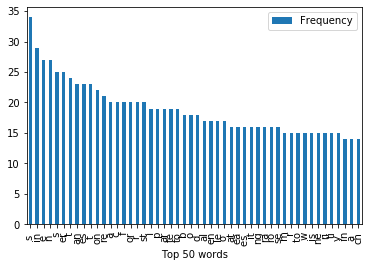

In [14]:
word_count_dict = {}
for word in vocab:
    word_count_dict[word] = int(sum(tfidf_char.loc[:, word]))

counter = Counter(word_count_dict)

freq_df = pandas.DataFrame.from_records(counter.most_common(50),
                                        columns=['Top 50 words', 'Frequency'])
freq_df.plot(kind='bar', x='Top 50 words');


 ## Word Embedding
 Build the Corpus Vocabulary

In [15]:
tokenizer = text.Tokenizer()
tokenizer.fit_on_texts(train_data_df.headline_cleaned)
word2id = tokenizer.word_index

# build vocabulary of unique words
word2id['PAD'] = 0
id2word = {v:k for k, v in word2id.items()}
wids = [[word2id[w] for w in text.text_to_word_sequence(doc)] for doc in train_data_df.headline_cleaned]

vocab_size = len(word2id)
embed_size = 100
window_size = 2 # context window size

print('Vocabulary Size:', vocab_size)
print('Vocabulary Sample:', list(word2id.items())[:100])


Vocabulary Size: 3170
Vocabulary Sample: [('to', 1), ('in', 2), ('for', 3), ('39', 4), ('on', 5), ('of', 6), ('the', 7), ('s', 8), ('a', 9), ('up', 10), ('b', 11), ('at', 12), ('new', 13), ('with', 14), ('us', 15), ('and', 16), ('says', 17), ('as', 18), ('by', 19), ('is', 20), ('oil', 21), ('1', 22), ('more', 23), ('china', 24), ('u', 25), ('no', 26), ('profit', 27), ('stocks', 28), ('iraq', 29), ('back', 30), ('win', 31), ('out', 32), ('report', 33), ('from', 34), ('ibm', 35), ('microsoft', 36), ('over', 37), ('open', 38), ('will', 39), ('it', 40), ('deal', 41), ('be', 42), ('sales', 43), ('bid', 44), ('world', 45), ('bush', 46), ('plans', 47), ('not', 48), ('off', 49), ('2', 50), ('quot', 51), ('cup', 52), ('prices', 53), ('india', 54), ('gets', 55), ('calls', 56), ('un', 57), ('kills', 58), ('buy', 59), ('can', 60), ('t', 61), ('get', 62), ('oracle', 63), ('000', 64), ('against', 65), ('fall', 66), ('iraqi', 67), ('plan', 68), ('are', 69), ('3', 70), ('may', 71), ('season', 72), ('a

In [16]:
# Build a CBOW (context, target) generator
def generate_context_word_pairs(corpus, window_size, vocab_size):
    context_length = window_size*2
    for words in corpus:
        sentence_length = len(words)
        for index, word in enumerate(words):
            context_words = []
            label_word   = []            
            start = index - window_size
            end = index + window_size + 1
            
            context_words.append([words[i] 
                                 for i in range(start, end) 
                                 if 0 <= i < sentence_length 
                                 and i != index])
            label_word.append(word)

            x = sequence.pad_sequences(context_words, maxlen=context_length)
            y = np_utils.to_categorical(label_word, vocab_size)
            yield (x, y)

# Test this out for some samples
i = 0
for x, y in generate_context_word_pairs(corpus=wids, window_size=window_size, vocab_size=vocab_size):
    if 0 not in x[0]:
        print('Context (X):', [id2word[w] for w in x[0]], '-> Target (Y):', id2word[numpy.argwhere(y[0])[0][0]])
    
        if i == 20:
            break
        i += 1


Context (X): ['nhl', 'on', 'maybe', 'for'] -> Target (Y): ice
Context (X): ['on', 'ice', 'for', 'whole'] -> Target (Y): maybe
Context (X): ['ice', 'maybe', 'whole', '2004'] -> Target (Y): for
Context (X): ['maybe', 'for', '2004', '05'] -> Target (Y): whole
Context (X): ['for', 'whole', '05', 'season'] -> Target (Y): 2004
Context (X): ['rowers', 'to', 'punished', 'for'] -> Target (Y): be
Context (X): ['to', 'be', 'for', 'criticism'] -> Target (Y): punished
Context (X): ['be', 'punished', 'criticism', 'of'] -> Target (Y): for
Context (X): ['punished', 'for', 'of', 'teammate'] -> Target (Y): criticism
Context (X): ['cassini', 'snapshots', 'moon', 'titan'] -> Target (Y): murky
Context (X): ['english', 'players', 'media', 'after'] -> Target (Y): snub
Context (X): ['players', 'snub', 'after', 'victory'] -> Target (Y): media
Context (X): ['explosives', 'were', 'after', 'iraq'] -> Target (Y): looted
Context (X): ['were', 'looted', 'iraq', 'invasion'] -> Target (Y): after
Context (X): ['mine', 

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 4, 100)            317000    
_________________________________________________________________
lambda_1 (Lambda)            (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 3170)              320170    
Total params: 637,170
Trainable params: 637,170
Non-trainable params: 0
_________________________________________________________________
None


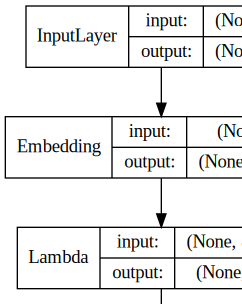

In [17]:

import keras.backend as K
from keras.models import Sequential
from keras.layers import Dense, Embedding, Lambda

# Build CBOW architecture
cbow = Sequential()
cbow.add(Embedding(input_dim=vocab_size, output_dim=embed_size, input_length=window_size*2))
cbow.add(Lambda(lambda x: K.mean(x, axis=1), output_shape=(embed_size,)))
cbow.add(Dense(vocab_size, activation='softmax'))
cbow.compile(loss='categorical_crossentropy', optimizer='rmsprop')

# view model summary
print(cbow.summary())

# visualize model structure
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(cbow, show_shapes=True, show_layer_names=False, rankdir='TB').create(prog='dot', format='svg'))
